## Plot feature distribution over time

In [27]:
import math

import pandas as pd

races_df = pd.read_csv("../data/races.csv")

races_df

,Unnamed: 0,date_time,race_id,n_runners,number,current_odds,current_place_odds,place,relevance,CurrentOdds,...,JockeyClassWinRate,TrainerDistanceWinRate,TrainerSurfaceWinRate,TrainerTrackWinRate,TrainerClassWinRate,RaceClassDifference,HasJockeyChanged,JockeyWeight,WeightAllowanceExtractor,MaxPastRatingExtractor
0,0,2017-12-01 13:00:00,2415941,11,1,6.5,2.1,4,15,6.5,...,0.107435,NaN,0.083918,0.000000,0.011281,0.0,1.0,74.4,0.0,NaN
1,1,2017-12-01 13:00:00,2415941,11,2,3.5,1.5,2,21,3.5,...,0.199818,NaN,0.202351,NaN,0.166508,0.0,0.0,71.7,0.0,NaN
2,2,2017-12-01 13:00:00,2415941,11,3,26.0,6.0,10,0,26.0,...,0.133849,NaN,0.360164,NaN,0.471882,-1.0,1.0,68.9,0.0,NaN
3,3,2017-12-01 13:00:00,2415941,11,4,101.0,21.0,11,0,101.0,...,0.041312,NaN,0.000000,NaN,0.000000,-2.0,1.0,68.9,0.0,NaN
4,4,2017-12-01 13:00:00,2415941,11,5,34.0,7.6,6,13,34.0,...,0.149075,NaN,0.226764,NaN,0.255685,0.0,1.0,68.9,1.4,76.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413873,413873,2022-08-31 20:55:00,5320979,11,7,9.5,2.7,7,23,9.5,...,0.142024,0.026173,0.191379,0.157022,0.196051,0.0,1.0,59.4,0.0,83.0
413874,413874,2022-08-31 20:55:00,5320979,11,8,6.5,2.1,4,27,6.5,...,0.183946,0.257032,0.031169,0.057144,0.127919,0.0,1.0,57.6,0.0,63.0
413875,413875,2022-08-31 20:55:00,5320979,11,9,12.0,3.2,8,18,12.0,...,0.036512,0.000000,0.005328,0.038321,0.045647,1.0,0.0,57.2,0.0,61.0
413876,413876,2022-08-31 20:55:00,5320979,11,10,12.0,3.2,9,15,12.0,...,0.095689,0.000000,0.034893,0.003283,0.083196,0.0,1.0,54.9,0.0,74.0


                  std
year-month           
2017-12     25.357114
2018-01     26.188726
2018-02     29.410578
2018-03     25.221973
2018-04     24.453951
2018-05     20.935029
2018-06     24.458747
2018-07     23.596953
2018-08     19.607695
2018-09     17.467480
2018-10     19.109522
2018-11     20.672481
2018-12     22.489777
2019-01     20.388547
2019-02     18.592763
2019-03     26.036881
2019-04     24.014033
2019-05     21.411615
2019-06     24.779431
2019-07     24.416860
2019-08     18.121358
2019-09     21.743304
2019-10     21.131690
2019-11     23.430585
2019-12     22.044535
2020-01     22.571964
2020-02     19.387071
2020-03     19.635354
2020-06     16.493952
2020-07     19.022962
2020-08     18.148235
2020-09     17.196941
2020-10     18.258163
2020-11     21.192931
2020-12     20.121462
2021-01     18.798307
2021-02     19.206312
2021-03     20.206397
2021-04     17.640329
2021-05     18.490992
2021-06     17.809868
2021-07     15.849775
2021-08     13.911121
2021-09   

<AxesSubplot:xlabel='CurrentSpeedFigure', ylabel='year-month'>

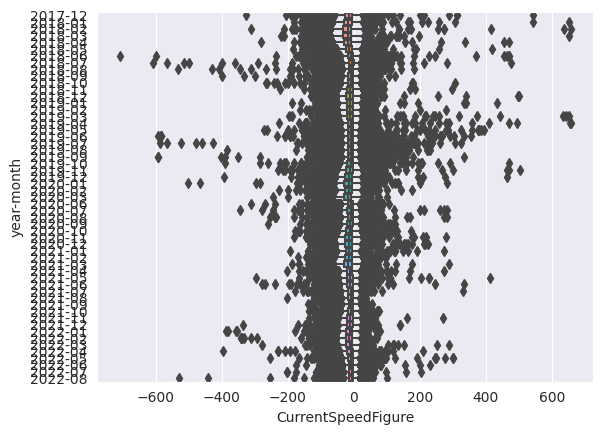

In [28]:
import seaborn as sns

COLUMN_NAME = "CurrentSpeedFigure"
TIME_INTERVAL = "year-month"

races_df["year-month"] = races_df["date_time"].astype(str).str[:7]
races_df["date"] = pd.to_datetime(races_df["date_time"], format='%Y-%m-%d')
races_df["dayofweek"] = races_df["date"].dt.dayofweek.astype(str)
races_df["hour"] = races_df["date"].dt.hour.astype(str)
races_df["minute"] = races_df["date"].dt.minute.astype(str)
races_df["month"] = races_df["date"].dt.month.astype(str)

print(races_df.groupby([TIME_INTERVAL]).agg(std=(COLUMN_NAME, "std")))

sns.boxplot(data=races_df, x=COLUMN_NAME, y=TIME_INTERVAL)

In [55]:
from numpy.random import normal
from scipy.stats import stats
from numpy import std
from math import isnan
from statistics import mean

speed_figures = list(races_df["CurrentSpeedFigure"].values)
speed_figures = [speed_figure for speed_figure in speed_figures if not isnan(speed_figure)]
print(mean(speed_figures))
print(std(speed_figures))

speed_figures_sample = normal(loc=-12.8, scale=20.38, size=10000)
stats.percentileofscore(speed_figures_sample, -20)

-12.800445569308796
20.38557260828779


/tmp/ipykernel_327506/3946010061.py:13: DeprecationWarning: Please use `percentileofscore` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  stats.percentileofscore(speed_figures_sample, -20)


36.68

# Covariate Shift Detection

## 1.) Between a month and its predecessor

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import numpy as np

races_df = pd.read_csv("../data/races.csv")
races_df["year-month"] = races_df["date_time"].astype(str).str[:7]

month_df = races_df[races_df["year-month"].isin(["2022-09", "2022-08"])]
month_df["label"] = np.where(month_df["year-month"] == "2022-09", 1, 0)

month_df = month_df.fillna(value=-1)

month_df = month_df.drop(["date_time", "race_id", "horse_id", "year-month", "Month_Sin", "Month_Cos", "Unnamed: 0"], axis=1)

print(month_df)

features = [column for column in month_df.columns if column not in ["label"]]
shift_X = month_df.loc[:, features]
scaler = StandardScaler().fit(shift_X)
shift_X = scaler.transform(shift_X)

shift_y = month_df.loc[:, "label"]

X_train, X_test, y_train, y_test = train_test_split(shift_X, shift_y, test_size=0.33, random_state=42, stratify=shift_y)

log_regression_classifier = LogisticRegression(random_state=0).fit(X_train, y_train)
print(f"Classifier score:{log_regression_classifier.score(X_test, y_test)}")

coef_data = {
    "feature name": list([column for column in features]),
    "coeff": list(list(log_regression_classifier.coef_)[0]),
}

coeff_df = pd.DataFrame.from_dict(coef_data)
coeff_df.sort_values(by=["coeff"])

       n_runners  current_odds  current_place_odds  place  has_won  relevance  \
80410         11          4.20                1.64      6        0         27   
80411         11         67.00               14.20      9        0         25   
80412         11         15.00                3.80      3        0         30   
80413         11         41.00                9.00     11        0         17   
80414         11         12.00                3.20      4        0         29   
...          ...           ...                 ...    ...      ...        ...   
92525         10          3.75                1.55      4        0         26   
92526         10         11.00                3.00      9        0         22   
92527         10         12.00                3.20      5        0         25   
92528         10         10.00                2.80      1        1         30   
92529         10         17.00                4.20      3        0         29   

       Current_Odds_Feature

/tmp/ipykernel_8287/2015652303.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  month_df["label"] = np.where(month_df["year-month"] == "2022-09", 1, 0)


,feature name,coeff
12,Draw_Bias,-0.377124
10,Age,-0.294436
1,current_odds,-0.280174
6,Current_Odds_Feature,-0.280174
11,Current_Rating,-0.240611
18,Hour_Cos,-0.177859
8,Current_Race_Class,-0.164490
14,Current_Race_Track,-0.159514
48,Average_Place_Surface,-0.119077
45,Jockey_Weight,-0.095458
